In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -Uq gdown
!pip install split-folders
!pip install natsort
!pip install torch transformers datasets evaluate pillow==9.2.0

!pip uninstall timm --y
!pip -q install --pre timm
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.5.0
    Uninstalling Pillow-9.5.0:
      Successfully uninstalled Pillow-9.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires scipy<1.10,>=1.4.1, but you have scipy 1.10.1 which is incompatible.
Found existing installation: timm 0.9.2
Uninstalling timm-0.9.2:
  Successfully uninstalled timm-0.9.2


In [3]:
import os
import numpy as np
import pandas as pd
import splitfolders
from glob import glob
# from tqdm import tqdm, trange
from tqdm.autonotebook import tqdm, trange
from numba import njit, jit
from natsort import natsorted

import matplotlib.pyplot as plt

#PIL
from PIL import Image, ImageOps

#random
from random import sample

#open cv
import cv2

#sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold

#scipy
from scipy import stats #ensemble

#pytorch
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader

#timm
import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

# import evaluate

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_25/67748980.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [4]:
train_files = glob("/kaggle/input/chest-ctscan-images/Data/train/**/*")

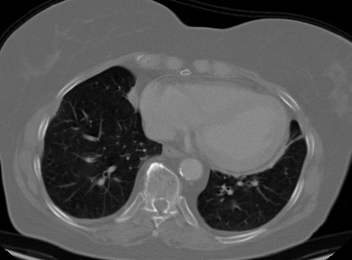

In [5]:
example = Image.open(train_files[1]).convert("RGB")
display(example)

In [6]:
img_size = 384
transforms = {
    "train": T.Compose([
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BICUBIC),
        # T.RandomRotation(5, fill=255), #fill = 255 เติม background เป็นสีขาว
        T.ToTensor(),
        # T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ]),
    "test": T.Compose([
        T.Resize((img_size, img_size), interpolation=T.InterpolationMode.BICUBIC),
        T.ToTensor(),
        # T.Normalize(mean=torch.tensor([0.4850, 0.4560, 0.4060]), std=torch.tensor([0.2290, 0.2240, 0.2250]))
    ])
}

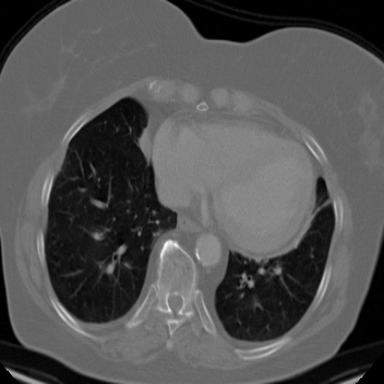

In [7]:
toImage = T.ToPILImage()
toImage(transforms["train"](example))


In [8]:
dataset = ImageDataset("/kaggle/input/chest-ctscan-images/Data/train", transform=transforms["train"])
id2label = natsorted(os.listdir('/kaggle/input/chest-ctscan-images/Data/train'))

In [9]:
id2label

['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib',
 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa',
 'normal',
 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']

In [10]:
len(train_files)

613

In [11]:
y = glob('/kaggle/input/chest-ctscan-images/Data/train/**/*')
y = natsorted(y)
y = [os.path.basename(os.path.dirname(i)) for i in y]

len(id2label), len(y) #len class, len sample

(4, 613)

## Train

In [12]:
from torchmetrics.classification import MulticlassF1Score

In [13]:
device = torch.device("cuda")
model_name = 'resnet50'
num_epochs = 10
criterion = nn.CrossEntropyLoss()

# Gradient Accumulation Settings
# Set to 1 for no accumulation
train_batch_size = 4
eval_batch_size = 4
num_accumulate = 4
num_classes = len(id2label)

# Cross Validation Configuration
k_splits = 5
metric = MulticlassF1Score(num_classes = 4)

In [14]:
timm.list_models()

In [15]:
all_eval_scores = []
eval_scores = []
!rm -rf croos_model
!mkdir croos_model

skf = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=42)
kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(dataset, y)):
# for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):

    print(f"\nFold {fold+1} of 5")

    # Load Model
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)

    # Load Optimizer and Scheduler
    optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
    
    scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

    # Load Data: split train and valition set based on kfold
    train_dataset = torch.utils.data.Subset(dataset, train_idx)
    val_dataset = torch.utils.data.Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

    # Reset Model Info
    info = {
        "metric_train": ['com'],
        "metric_val": ['com'],
        "train_loss": ['com'],
        "val_loss": ['com'],
        "best_metric_val": -999,
    }
    
    count = 0
    eval_scores.append([])
    for epoch in range(num_epochs):

        train_loss_epoch = []
        val_loss_epoch = []
    
        train_preds = []
        train_targets = []
    
        val_preds = []
        val_targets = []
    
        num_updates = epoch * len(train_dataloader)
    
        ### === Train Loop === ###

        model.train()
        for idx, batch in enumerate(tqdm(train_dataloader)):
            inputs, targets = batch
            outputs = model(inputs.to(device))
            loss = criterion(outputs, targets.to(device))
    
            loss.backward()
    
            # === Gradient Accumulation === #
            if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
                optimizer.step()
                scheduler.step_update(num_updates=num_updates)
                optimizer.zero_grad()
            # ============================= #
    
            train_loss_epoch.append(loss.item())
            train_preds += outputs.argmax(-1).detach().cpu().tolist()
            train_targets += targets.tolist()

        optimizer.step()
        scheduler.step(epoch + 1)
    
        ### === Evaluation Loop === ###
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                inputs, targets = batch
                outputs = model(inputs.to(device))
                loss = criterion(outputs, targets.to(device))
    
                # Log Values
                val_loss_epoch.append(loss.item())
                val_preds += outputs.argmax(-1).detach().cpu().tolist()
                val_targets += targets.tolist()
        ### ======================= ###
        
        # Log Data
        
        train_preds = torch.FloatTensor(train_preds)
        train_targets = torch.FloatTensor(train_targets)
        val_preds = torch.FloatTensor(val_preds)
        val_targets = torch.FloatTensor(val_targets)

        metric_train = metric(train_preds, train_targets)
        metric_val = metric(val_preds, val_targets)
    
        info["metric_train"][0] = metric_train
        info["metric_val"][0] = metric_val
    
        info["train_loss"][0] = np.average(train_loss_epoch)
        info["val_loss"][0] = np.average(val_loss_epoch)
        
        eval_scores[-1].append(metric_val)
        if metric_val > info["best_metric_val"]:
            print("\nNew Best Score!")
            info["best_metric_val"] = metric_val
            torch.save(model, f"croos_model/checkpoint_fold{fold}.pt")
            count = 0

        else:
            count += 1
        
        print(info)
        print(f"Fold: {fold} | Epoch: {epoch} | Metric: {metric_val} | Training Loss: {np.average(train_loss_epoch)} | Validation Loss: {np.average(val_loss_epoch)}\n")
        
        
    all_eval_scores.append(info["best_metric_val"])


Fold 1 of 5


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3655)], 'metric_val': [tensor(0.4762)], 'train_loss': [1.1967972420095427], 'val_loss': [0.9085696435743763], 'best_metric_val': tensor(0.4762)}
Fold: 0 | Epoch: 0 | Metric: 0.4761512577533722 | Training Loss: 1.1967972420095427 | Validation Loss: 0.9085696435743763



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6891)], 'metric_val': [tensor(0.7386)], 'train_loss': [0.7731729373941577], 'val_loss': [0.6425108577935926], 'best_metric_val': tensor(0.7386)}
Fold: 0 | Epoch: 1 | Metric: 0.7385707497596741 | Training Loss: 0.7731729373941577 | Validation Loss: 0.6425108577935926



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8479)], 'metric_val': [tensor(0.8426)], 'train_loss': [0.43527177715204596], 'val_loss': [0.4012251851269074], 'best_metric_val': tensor(0.8426)}
Fold: 0 | Epoch: 2 | Metric: 0.842637300491333 | Training Loss: 0.43527177715204596 | Validation Loss: 0.4012251851269074



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8976)], 'metric_val': [tensor(0.9421)], 'train_loss': [0.28201510764779597], 'val_loss': [0.19621606424991642], 'best_metric_val': tensor(0.9421)}
Fold: 0 | Epoch: 3 | Metric: 0.9420741200447083 | Training Loss: 0.28201510764779597 | Validation Loss: 0.19621606424991642



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9563)], 'metric_val': [tensor(0.9446)], 'train_loss': [0.1638314327001723], 'val_loss': [0.12895346643222916], 'best_metric_val': tensor(0.9446)}
Fold: 0 | Epoch: 4 | Metric: 0.9445801973342896 | Training Loss: 0.1638314327001723 | Validation Loss: 0.12895346643222916



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9899)], 'metric_val': [tensor(0.9768)], 'train_loss': [0.06487897374265926], 'val_loss': [0.06879226660220733], 'best_metric_val': tensor(0.9768)}
Fold: 0 | Epoch: 5 | Metric: 0.9767540693283081 | Training Loss: 0.06487897374265926 | Validation Loss: 0.06879226660220733



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9870)], 'metric_val': [tensor(0.9693)], 'train_loss': [0.06681798972431721], 'val_loss': [0.11155502404524727], 'best_metric_val': tensor(0.9768)}
Fold: 0 | Epoch: 6 | Metric: 0.9692537784576416 | Training Loss: 0.06681798972431721 | Validation Loss: 0.11155502404524727



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9976)], 'metric_val': [tensor(0.9766)], 'train_loss': [0.03462329103774202], 'val_loss': [0.06777648358383298], 'best_metric_val': tensor(0.9768)}
Fold: 0 | Epoch: 7 | Metric: 0.976637601852417 | Training Loss: 0.03462329103774202 | Validation Loss: 0.06777648358383298



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9955)], 'metric_val': [tensor(0.9693)], 'train_loss': [0.041528546373923954], 'val_loss': [0.08268670612291786], 'best_metric_val': tensor(0.9768)}
Fold: 0 | Epoch: 8 | Metric: 0.9692537784576416 | Training Loss: 0.041528546373923954 | Validation Loss: 0.08268670612291786



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9934)], 'metric_val': [tensor(0.9604)], 'train_loss': [0.02481861300794862], 'val_loss': [0.08951312995369305], 'best_metric_val': tensor(0.9768)}
Fold: 0 | Epoch: 9 | Metric: 0.9604310393333435 | Training Loss: 0.02481861300794862 | Validation Loss: 0.08951312995369305


Fold 2 of 5


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3887)], 'metric_val': [tensor(0.4049)], 'train_loss': [1.2004933211861588], 'val_loss': [1.320879673284869], 'best_metric_val': tensor(0.4049)}
Fold: 1 | Epoch: 0 | Metric: 0.40494537353515625 | Training Loss: 1.2004933211861588 | Validation Loss: 1.320879673284869



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6864)], 'metric_val': [tensor(0.6994)], 'train_loss': [0.7499078432234322], 'val_loss': [4.536809430968377], 'best_metric_val': tensor(0.6994)}
Fold: 1 | Epoch: 1 | Metric: 0.6994471549987793 | Training Loss: 0.7499078432234322 | Validation Loss: 4.536809430968377



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8619)], 'metric_val': [tensor(0.8200)], 'train_loss': [0.42339778158480557], 'val_loss': [3.780096957520131], 'best_metric_val': tensor(0.8200)}
Fold: 1 | Epoch: 2 | Metric: 0.8199929594993591 | Training Loss: 0.42339778158480557 | Validation Loss: 3.780096957520131



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9089)], 'metric_val': [tensor(0.8904)], 'train_loss': [0.2892865087019234], 'val_loss': [0.2479397257820012], 'best_metric_val': tensor(0.8904)}
Fold: 1 | Epoch: 3 | Metric: 0.8903709650039673 | Training Loss: 0.2892865087019234 | Validation Loss: 0.2479397257820012



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9673)], 'metric_val': [tensor(0.9905)], 'train_loss': [0.13028572536474928], 'val_loss': [0.0883897463528199], 'best_metric_val': tensor(0.9905)}
Fold: 1 | Epoch: 4 | Metric: 0.9904761910438538 | Training Loss: 0.13028572536474928 | Validation Loss: 0.0883897463528199



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9894)], 'metric_val': [tensor(0.9819)], 'train_loss': [0.059522700438283505], 'val_loss': [0.09574765899413896], 'best_metric_val': tensor(0.9905)}
Fold: 1 | Epoch: 5 | Metric: 0.9819154739379883 | Training Loss: 0.059522700438283505 | Validation Loss: 0.09574765899413896



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9895)], 'metric_val': [tensor(0.9811)], 'train_loss': [0.04048410704363198], 'val_loss': [0.06957694959372372], 'best_metric_val': tensor(0.9905)}
Fold: 1 | Epoch: 6 | Metric: 0.9810659289360046 | Training Loss: 0.04048410704363198 | Validation Loss: 0.06957694959372372



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9934)], 'metric_val': [tensor(0.9834)], 'train_loss': [0.04167860277646365], 'val_loss': [0.07269613302431084], 'best_metric_val': tensor(0.9905)}
Fold: 1 | Epoch: 7 | Metric: 0.9833852052688599 | Training Loss: 0.04167860277646365 | Validation Loss: 0.07269613302431084



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9955)], 'metric_val': [tensor(0.9905)], 'train_loss': [0.024474572314600634], 'val_loss': [0.05731712464307014], 'best_metric_val': tensor(0.9905)}
Fold: 1 | Epoch: 8 | Metric: 0.9904761910438538 | Training Loss: 0.024474572314600634 | Validation Loss: 0.05731712464307014



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9958)], 'metric_val': [tensor(0.9747)], 'train_loss': [0.029643759382245078], 'val_loss': [0.07452387300896414], 'best_metric_val': tensor(0.9905)}
Fold: 1 | Epoch: 9 | Metric: 0.9747389554977417 | Training Loss: 0.029643759382245078 | Validation Loss: 0.07452387300896414


Fold 3 of 5


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.4176)], 'metric_val': [tensor(0.5217)], 'train_loss': [1.1599634803407561], 'val_loss': [0.8938735883322454], 'best_metric_val': tensor(0.5217)}
Fold: 2 | Epoch: 0 | Metric: 0.5216705799102783 | Training Loss: 1.1599634803407561 | Validation Loss: 0.8938735883322454



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6607)], 'metric_val': [tensor(0.6996)], 'train_loss': [0.7632596243203171], 'val_loss': [0.6685256008359213], 'best_metric_val': tensor(0.6996)}
Fold: 2 | Epoch: 1 | Metric: 0.6996305584907532 | Training Loss: 0.7632596243203171 | Validation Loss: 0.6685256008359213



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8575)], 'metric_val': [tensor(0.8374)], 'train_loss': [0.4314676900280685], 'val_loss': [0.42516116978180024], 'best_metric_val': tensor(0.8374)}
Fold: 2 | Epoch: 2 | Metric: 0.8374291658401489 | Training Loss: 0.4314676900280685 | Validation Loss: 0.42516116978180024



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8792)], 'metric_val': [tensor(0.9163)], 'train_loss': [0.32783744777969226], 'val_loss': [0.3260513417903454], 'best_metric_val': tensor(0.9163)}
Fold: 2 | Epoch: 3 | Metric: 0.9162729978561401 | Training Loss: 0.32783744777969226 | Validation Loss: 0.3260513417903454



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9589)], 'metric_val': [tensor(0.9053)], 'train_loss': [0.1475449189490722], 'val_loss': [0.23369774555284228], 'best_metric_val': tensor(0.9163)}
Fold: 2 | Epoch: 4 | Metric: 0.905344545841217 | Training Loss: 0.1475449189490722 | Validation Loss: 0.23369774555284228



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9780)], 'metric_val': [tensor(0.9543)], 'train_loss': [0.08762497098347914], 'val_loss': [0.1323355087792621], 'best_metric_val': tensor(0.9543)}
Fold: 2 | Epoch: 5 | Metric: 0.9542710781097412 | Training Loss: 0.08762497098347914 | Validation Loss: 0.1323355087792621



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9782)], 'metric_val': [tensor(0.9597)], 'train_loss': [0.06532605496288194], 'val_loss': [0.1000780881112141], 'best_metric_val': tensor(0.9597)}
Fold: 2 | Epoch: 6 | Metric: 0.959686815738678 | Training Loss: 0.06532605496288194 | Validation Loss: 0.1000780881112141



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9953)], 'metric_val': [tensor(0.9695)], 'train_loss': [0.03161640158131325], 'val_loss': [0.10254222231601635], 'best_metric_val': tensor(0.9695)}
Fold: 2 | Epoch: 7 | Metric: 0.9694610834121704 | Training Loss: 0.03161640158131325 | Validation Loss: 0.10254222231601635



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9978)], 'metric_val': [tensor(0.9695)], 'train_loss': [0.025571011852026287], 'val_loss': [0.10507453002426173], 'best_metric_val': tensor(0.9695)}
Fold: 2 | Epoch: 8 | Metric: 0.9695127606391907 | Training Loss: 0.025571011852026287 | Validation Loss: 0.10507453002426173



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9976)], 'metric_val': [tensor(0.9597)], 'train_loss': [0.02286288823801797], 'val_loss': [0.10697177040480799], 'best_metric_val': tensor(0.9695)}
Fold: 2 | Epoch: 9 | Metric: 0.959686815738678 | Training Loss: 0.02286288823801797 | Validation Loss: 0.10697177040480799


Fold 4 of 5


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3547)], 'metric_val': [tensor(0.5916)], 'train_loss': [1.2575135037181824], 'val_loss': [0.9675205849832104], 'best_metric_val': tensor(0.5916)}
Fold: 3 | Epoch: 0 | Metric: 0.5915844440460205 | Training Loss: 1.2575135037181824 | Validation Loss: 0.9675205849832104



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6652)], 'metric_val': [tensor(0.6930)], 'train_loss': [0.8180284982289725], 'val_loss': [0.6131571670092882], 'best_metric_val': tensor(0.6930)}
Fold: 3 | Epoch: 1 | Metric: 0.6929671168327332 | Training Loss: 0.8180284982289725 | Validation Loss: 0.6131571670092882



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8247)], 'metric_val': [tensor(0.8332)], 'train_loss': [0.4780493683628435], 'val_loss': [0.4670834695589879], 'best_metric_val': tensor(0.8332)}
Fold: 3 | Epoch: 2 | Metric: 0.833240270614624 | Training Loss: 0.4780493683628435 | Validation Loss: 0.4670834695589879



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9222)], 'metric_val': [tensor(0.8787)], 'train_loss': [0.2576041670470703], 'val_loss': [0.343103680846041], 'best_metric_val': tensor(0.8787)}
Fold: 3 | Epoch: 3 | Metric: 0.8787456154823303 | Training Loss: 0.2576041670470703 | Validation Loss: 0.343103680846041



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9412)], 'metric_val': [tensor(0.9382)], 'train_loss': [0.18389641386418928], 'val_loss': [0.18696620301559433], 'best_metric_val': tensor(0.9382)}
Fold: 3 | Epoch: 4 | Metric: 0.9382432699203491 | Training Loss: 0.18389641386418928 | Validation Loss: 0.18696620301559433



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9834)], 'metric_val': [tensor(0.9740)], 'train_loss': [0.09697514134497057], 'val_loss': [0.1081146486704388], 'best_metric_val': tensor(0.9740)}
Fold: 3 | Epoch: 5 | Metric: 0.9739789366722107 | Training Loss: 0.09697514134497057 | Validation Loss: 0.1081146486704388



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9885)], 'metric_val': [tensor(0.9714)], 'train_loss': [0.06154742070882604], 'val_loss': [0.10279820706730994], 'best_metric_val': tensor(0.9740)}
Fold: 3 | Epoch: 6 | Metric: 0.9714285731315613 | Training Loss: 0.06154742070882604 | Validation Loss: 0.10279820706730994



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9924)], 'metric_val': [tensor(0.9737)], 'train_loss': [0.05455714128476121], 'val_loss': [0.09801934603174525], 'best_metric_val': tensor(0.9740)}
Fold: 3 | Epoch: 7 | Metric: 0.9736707806587219 | Training Loss: 0.05455714128476121 | Validation Loss: 0.09801934603174525



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9928)], 'metric_val': [tensor(0.9740)], 'train_loss': [0.03381111531715265], 'val_loss': [0.09944553716547577], 'best_metric_val': tensor(0.9740)}
Fold: 3 | Epoch: 8 | Metric: 0.9739789366722107 | Training Loss: 0.03381111531715265 | Validation Loss: 0.09944553716547577



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9941)], 'metric_val': [tensor(0.9811)], 'train_loss': [0.029288075336186988], 'val_loss': [0.09239908916530229], 'best_metric_val': tensor(0.9811)}
Fold: 3 | Epoch: 9 | Metric: 0.9810659289360046 | Training Loss: 0.029288075336186988 | Validation Loss: 0.09239908916530229


Fold 5 of 5


  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.3368)], 'metric_val': [tensor(0.5363)], 'train_loss': [1.2337961405273374], 'val_loss': [0.9044270332782499], 'best_metric_val': tensor(0.5363)}
Fold: 4 | Epoch: 0 | Metric: 0.5363187789916992 | Training Loss: 1.2337961405273374 | Validation Loss: 0.9044270332782499



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.6124)], 'metric_val': [tensor(0.6481)], 'train_loss': [0.8209985644836736], 'val_loss': [0.727058736186835], 'best_metric_val': tensor(0.6481)}
Fold: 4 | Epoch: 1 | Metric: 0.6480578184127808 | Training Loss: 0.8209985644836736 | Validation Loss: 0.727058736186835



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.8347)], 'metric_val': [tensor(0.8581)], 'train_loss': [0.4995494873179653], 'val_loss': [0.3680368875183405], 'best_metric_val': tensor(0.8581)}
Fold: 4 | Epoch: 2 | Metric: 0.858109712600708 | Training Loss: 0.4995494873179653 | Validation Loss: 0.3680368875183405



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9083)], 'metric_val': [tensor(0.8869)], 'train_loss': [0.2810719605171826], 'val_loss': [0.38147359674856546], 'best_metric_val': tensor(0.8869)}
Fold: 4 | Epoch: 3 | Metric: 0.8869239687919617 | Training Loss: 0.2810719605171826 | Validation Loss: 0.38147359674856546



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9504)], 'metric_val': [tensor(0.8800)], 'train_loss': [0.19349563509089554], 'val_loss': [0.32437510428679805], 'best_metric_val': tensor(0.8869)}
Fold: 4 | Epoch: 4 | Metric: 0.8799794912338257 | Training Loss: 0.19349563509089554 | Validation Loss: 0.32437510428679805



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9763)], 'metric_val': [tensor(0.9319)], 'train_loss': [0.11443512052736753], 'val_loss': [0.2417440402824732], 'best_metric_val': tensor(0.9319)}
Fold: 4 | Epoch: 5 | Metric: 0.9318958520889282 | Training Loss: 0.11443512052736753 | Validation Loss: 0.2417440402824732



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9863)], 'metric_val': [tensor(0.9525)], 'train_loss': [0.06291472865079295], 'val_loss': [0.16183804632765392], 'best_metric_val': tensor(0.9525)}
Fold: 4 | Epoch: 6 | Metric: 0.9525402784347534 | Training Loss: 0.06291472865079295 | Validation Loss: 0.16183804632765392



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

{'metric_train': [tensor(0.9976)], 'metric_val': [tensor(0.9439)], 'train_loss': [0.037308337235050955], 'val_loss': [0.16785088039356313], 'best_metric_val': tensor(0.9525)}
Fold: 4 | Epoch: 7 | Metric: 0.9439349174499512 | Training Loss: 0.037308337235050955 | Validation Loss: 0.16785088039356313



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9939)], 'metric_val': [tensor(0.9610)], 'train_loss': [0.035563790848444604], 'val_loss': [0.15004058421829775], 'best_metric_val': tensor(0.9610)}
Fold: 4 | Epoch: 8 | Metric: 0.9609955549240112 | Training Loss: 0.035563790848444604 | Validation Loss: 0.15004058421829775



  0%|          | 0/123 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]


New Best Score!
{'metric_train': [tensor(0.9940)], 'metric_val': [tensor(0.9691)], 'train_loss': [0.03467889129926216], 'val_loss': [0.15494607603027216], 'best_metric_val': tensor(0.9691)}
Fold: 4 | Epoch: 9 | Metric: 0.9690791964530945 | Training Loss: 0.03467889129926216 | Validation Loss: 0.15494607603027216



In [16]:
all_eval_scores

[tensor(0.9768),
 tensor(0.9905),
 tensor(0.9695),
 tensor(0.9811),
 tensor(0.9691)]

In [17]:
eval_scores

[[tensor(0.4762),
  tensor(0.7386),
  tensor(0.8426),
  tensor(0.9421),
  tensor(0.9446),
  tensor(0.9768),
  tensor(0.9693),
  tensor(0.9766),
  tensor(0.9693),
  tensor(0.9604)],
 [tensor(0.4049),
  tensor(0.6994),
  tensor(0.8200),
  tensor(0.8904),
  tensor(0.9905),
  tensor(0.9819),
  tensor(0.9811),
  tensor(0.9834),
  tensor(0.9905),
  tensor(0.9747)],
 [tensor(0.5217),
  tensor(0.6996),
  tensor(0.8374),
  tensor(0.9163),
  tensor(0.9053),
  tensor(0.9543),
  tensor(0.9597),
  tensor(0.9695),
  tensor(0.9695),
  tensor(0.9597)],
 [tensor(0.5916),
  tensor(0.6930),
  tensor(0.8332),
  tensor(0.8787),
  tensor(0.9382),
  tensor(0.9740),
  tensor(0.9714),
  tensor(0.9737),
  tensor(0.9740),
  tensor(0.9811)],
 [tensor(0.5363),
  tensor(0.6481),
  tensor(0.8581),
  tensor(0.8869),
  tensor(0.8800),
  tensor(0.9319),
  tensor(0.9525),
  tensor(0.9439),
  tensor(0.9610),
  tensor(0.9691)]]

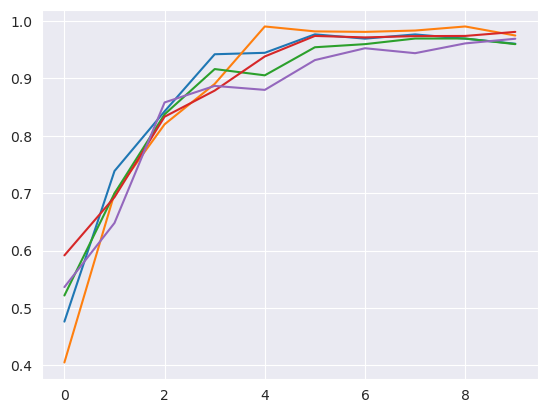

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("darkgrid")
for i in range(5):
    plt.plot(eval_scores[i])

plt.show()